In [1]:
import numpy as np
import sep

In [2]:
from astropy.io import fits
import matplotlib.pyplot as mlp
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

**Image Display**

via SEP instruction linked, define the F105W band image of the Hubble Ultra Deep Field from the FITS file
defined ->

In [3]:
#defining file name
fdata_F105W = "hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits"
#read data
hdu_2 = fits.open(fdata_F105W)
#get image data
data_2 = hdu_2[0].data

Displaying the image ->

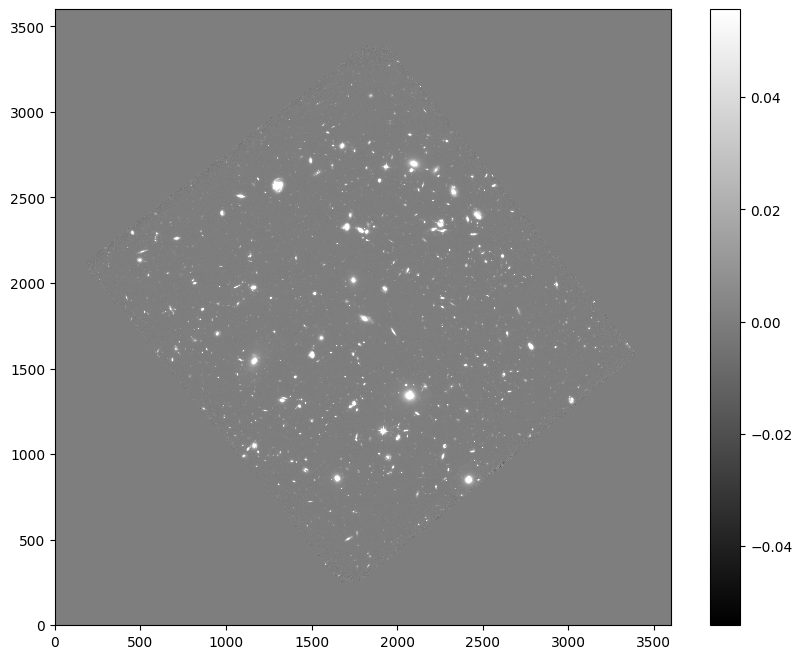

In [4]:
#show the image
m, s = np.mean(data_2), np.std(data_2)
mlp.imshow(data_2, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
mlp.colorbar();
mlp.savefig('HUDF_Image.png',bbox_inches="tight",dpi=600)

**Background Subtraction**

Using SEP to substract background and find sources

In [5]:
#data
data = data_2.byteswap(inplace=True).newbyteorder()
#measure spatially varying background on the image
bkg = sep.Background(data)
#getting "global" mean and noise of image background:
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


In [6]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

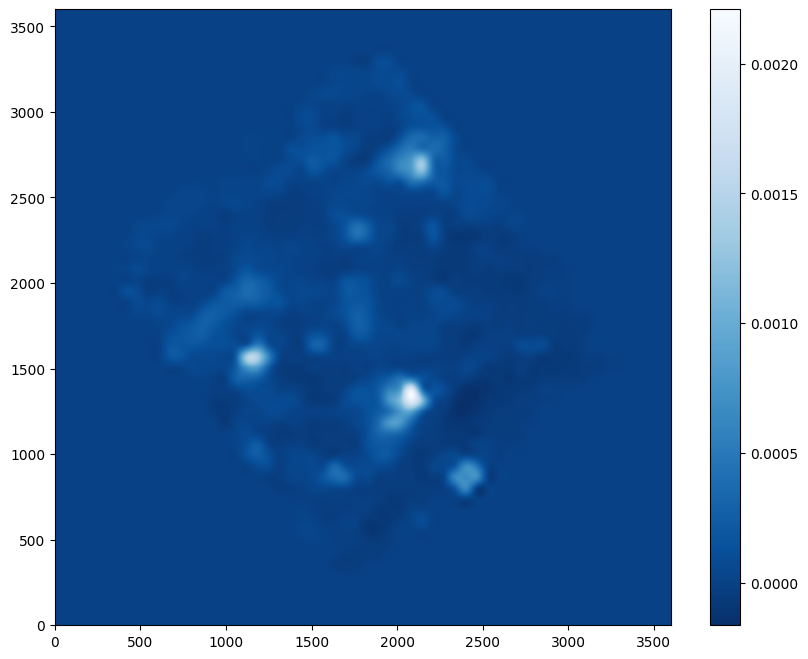

In [8]:
# show the background
mlp.imshow(bkg_image, interpolation='nearest', cmap='Blues_r', origin='lower')
mlp.colorbar();
mlp.savefig('HUDF_Background_Image.png',bbox_inches="tight",dpi=600)

In [9]:
#Subtracting the background
data_sub = data - bkg

**Object Detection**

With the removal of background noise, we can now run object detection on the data, and according to the SEP tutorial, the detection threshold should be at the constant value 1.5σ where σis the global background RMS (root mean square)

In [10]:
#define 'objects'
objects =sep.extract(data_sub, 1.5, err=bkg.globalrms)
# how many objects were detected
len(objects)

8640

Now that we have the number of objects, we can check the location of detected objects ->

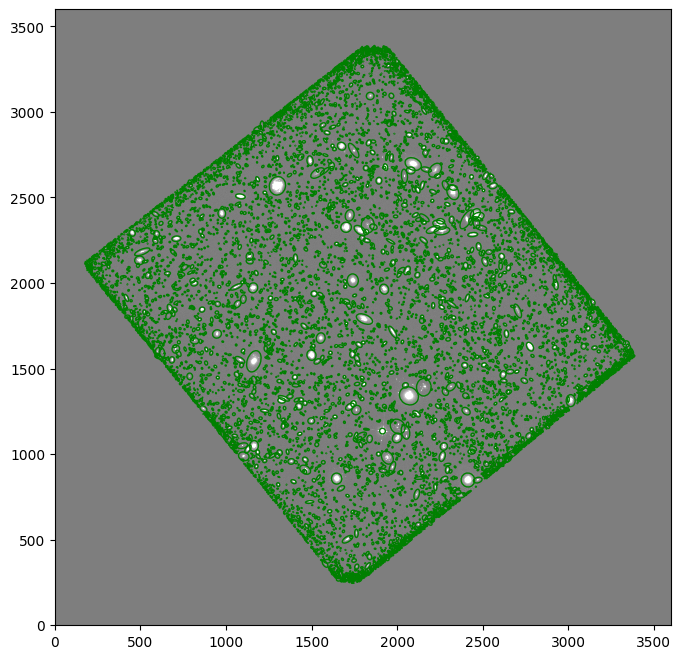

In [12]:
#How to circle objects via matplotlib Ellipses
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = mlp.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('green')
    ax.add_artist(e)

**Aperture photometry**

Finally, we’ll perform simple circular aperture photometry with a 3 pixel radius at the locations of the objects:

In [13]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [14]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


**Histogram Code**



Mean of the fluxes is 0.36185728037707154.
Median of the fluxes is 0.030960064365426664.
Standard Deviation of the fluxes is 9.243528029706706.
The outlier is 807.2972835731507.
The number of deviations that the outlier lies from the mean is 87.29734184820526.


<function matplotlib.pyplot.show(close=None, block=None)>

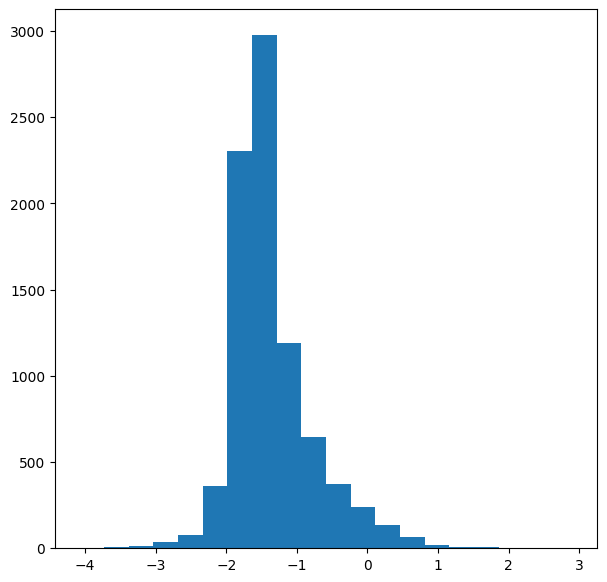

In [16]:
flux_mean = np.mean(flux)
flux_std = np.std(flux)
flux_median = np.median(flux)
flux_outlier = np.max(flux)

num_stds = ((flux_outlier - flux_mean) / flux_std)

print(f"Mean of the fluxes is {flux_mean}.")
print(f"Median of the fluxes is {flux_median}.")
print(f"Standard Deviation of the fluxes is {flux_std}.")
print(f"The outlier is {flux_outlier}.")
print(f"The number of deviations that the outlier lies from the mean is {num_stds}.")

#To not get a log10 error
valid_flux = flux[flux > 0]
f, ax = mlp.subplots(1,1, figsize=(7,7))
ax.hist(np.log10(valid_flux), bins=20)
mlp.show

**FITS Files and RGB Image**

file handling ->

In [21]:
fdata_F105W="hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits"
fdata_F125W="hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits"
fdata_F160W="hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits"

hdu_2=fits.open(fdata_F105W)
hdu_3=fits.open(fdata_F125W)
hdu_4=fits.open(fdata_F160W)

data_2=hdu_2[0].data
data_3=hdu_3[0].data
data_4=hdu_4[0].data

Rescaling and Creating the Combination False Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


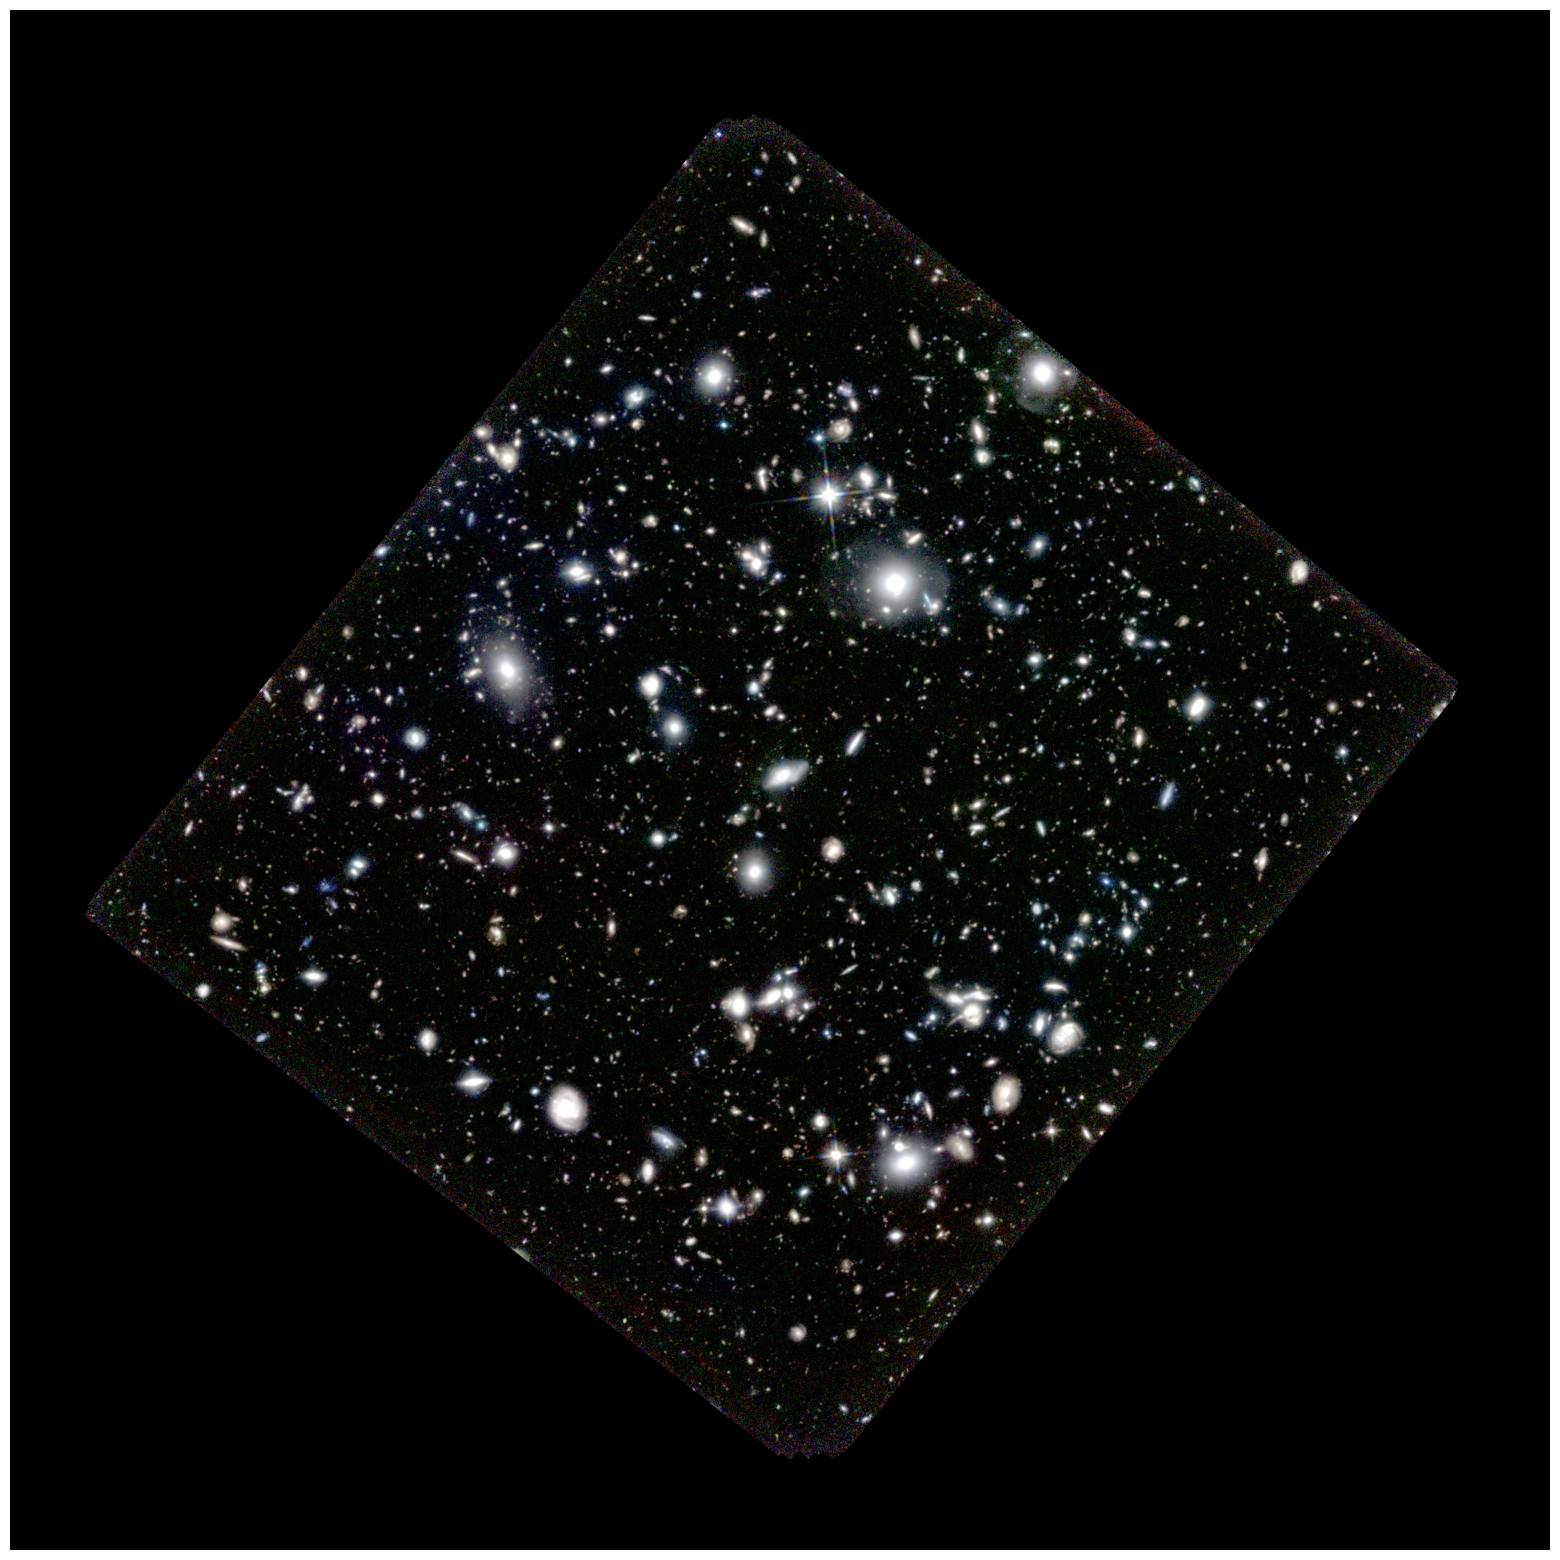

In [22]:
def rescale_image(data):
    pdata_tmp=data.copy()
    m=np.nanmean(pdata_tmp)
    vplmin=m/2.
    vpmin=np.log10(vplmin)
    vpmax=np.log10(m*100.)
    pdata_tmp[pdata_tmp<vplmin]=vplmin
    pdata_tmp=np.log10(pdata_tmp)
    return pdata_tmp,vpmin,vpmax

data_2_res, d2min,d2max=rescale_image(data_2)
data_3_res, d3min,d3max=rescale_image(data_3)
data_4_res, d4min,d4max=rescale_image(data_4)

data_2_res[data_2_res<d2min]=d2min
data_2_res[data_2_res>d2max]=d2max
data_3_res[data_3_res<d3min]=d3min
data_3_res[data_3_res>d3max]=d3max
data_4_res[data_4_res<d4min]=d4min
data_4_res[data_4_res>d4max]=d4max

rgb=np.zeros((data_2_res.shape[0],data_2_res.shape[1],3))
rgb[:,:,0]=(data_2_res-d2min)/(d2max-d2min)
rgb[:,:,1]=(data_3_res-d3min)/(d3max-d3min)
rgb[:,:,2]=(data_4_res-d4min)/(d4max-d4mi  n)

f,ax=mlp.subplots(1,1,figsize=(20,20))
ax.axis('off')
ax.imshow(rgb)
mlp.savefig('FinalRBG.png', bbox_inches='tight',pad_inches=0,dpi=600)